# Assignment-2: Manifold Learning

The objective of this assignment is to apply the concepts you have learned in class on Manifold Learning and Spectral Clustering. 

## Instructions
  - For each question you need to write the sub-problem formulation in markdown. 
  - Ensure that this notebook runs without errors when the cells are run in sequence.
  - Plagiarism will not be tolerated.
  - Use only `python3` to run your code.
  - If you are facing issues running the notebook on your local system. Use google collab to run the notebook online. To run the notebook online, go to [google collab](!https://colab.research.google.com/notebooks/intro.ipynb). Go to `File  -> Upload Notebook` and import the notebook file.

__NOTE__: If you use online platforms, you will have to upload `swissroll.dat` file separately and change the path in the code cell which loads the data.

## Submission  
- Rename the notebook to `<roll_number>.ipynb` and submit **ONLY** the notebook file on moodle.

## Problems 
 - Question 1: Spectral Clustering (10 marks)
 - Question 2: Manifold Visualization (10 marks)
 - Question 3: Clustering and Visualizing high-dimensional data (10 marks)
 - Question 4: Classification (10 marks)

## Deadline 
The deadline of this assignment is 27th April, 2020, 11:59 PM

In [3]:
import sys
# Install packages correctly
#!{sys.executable} -m pip install numpy sklearn tensorflow keras
# Fix mpl version due to subtle API differences
##!{sys.executable} -m pip install matplotlib==3.0.3

import numpy as np
# Allow usage of both `np` and `numpy`
from sklearn.neighbors import kneighbors_graph
from scipy.sparse import csgraph
from scipy.sparse.csgraph import shortest_path
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from sklearn.cluster import KMeans

# Question 1: Spectral Clustering

Implement spectral clustering and evaluate on the given concentric circles dataset for this question.

## Part 1: Implementation
Implement spectral clustering function from scratch (for two clusters), taking as input the dataset. It must return the predicted clustering. Assume that the graph constructed is a fully connected graph. Use the normalized graph laplacian for this case.



In [4]:
# Part 1: Spectral Clustering

def spectral_clustering(X):
  """Args:
    X: numpy.array [num_samples, input_dim]
    
    Returns:
    Y_pred: numpy.array [num_samples]
      array of cluster labels
  """
  # Your code here

  A = kneighbors_graph(X, 2, mode='distance', metric='minkowski', p=2)
  A = A.toarray()
  L = csgraph.laplacian(A, normed=True)
  eigval, eigvec = np.linalg.eig(L)
  idx = np.argmin(eigval)
  Y_pred = eigvec[:,idx].copy()
  Y_pred[Y_pred < 0] = 0
  Y_pred[Y_pred > 0] = 1
  return Y_pred


## Part 2: Clustering concentric circles
Perform spectral clustering on the concentric circles dataset. Visualize the result by plotting it on a 2-d graph. Use different colours for different clusters.

In [5]:
# DO NOT EDIT

from sklearn.datasets import make_circles 

CX, CY = make_circles(n_samples=200, shuffle=True,noise=0.05, random_state=1337, factor=0.5)
# CX: input data points [n_samples, 2]
# CY: true clusters [n_samples]

In [6]:
# Part 2: Perform Spectral Clustering on the concentric circles dataset
# Plot using colors from CY (true clusters) and CY_pred (predicted clusters)
# Code in this cell should plot 2 subplots (true labels and predicted labels)
CY_Pred = spectral_clustering(CX)

## Part 3: Evaluate accuracy
Evaluate the accuracy of the clustering by comparing it with the true labels. Create two subplots (true vs predicted) with the color of each point showing the cluster label.

Accuracy :  0.47


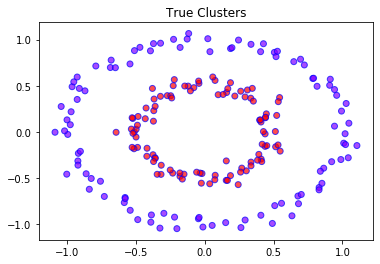

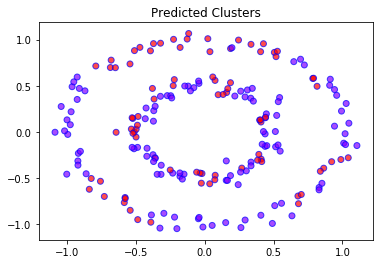

In [7]:
# Part 3: Report the accuracy of clustering
from sklearn.metrics import accuracy_score
print('Accuracy : ',accuracy_score(CY, CY_Pred))
plt.scatter(CX[:,0], CX[:,1], c=CY, cmap='rainbow', alpha=0.7, edgecolors='b')
plt.title('True Clusters')
plt.show()
plt.title('Predicted Clusters')
plt.scatter(CX[:,0], CX[:,1], c=CY_Pred, cmap='rainbow', alpha=0.7, edgecolors='b')
plt.show()



---



# Question 2: Manifold Visualization
Implement the various manifold learning methods and visualize the given datasets.


## Part 1: MDS
Implement Multi-Dimensional Scaling

In [8]:
# Part 1: MDS
from sklearn.metrics import pairwise_distances
def MDS(X, k, output_dim=2):
  """Args:
    X: numpy.array [n_samples, input_dim]
    k: number of nearest neighbours to construct the knn graph
    output_dim: dimension of output data

    Returns:
    Y: numpy.array [n_samples, output_dim]
  """
  # Your code here
  # Compute disimmilarity matrix
  D = pairwise_distances(X)
  n = len(D)
 
  # Centering matrix                                                                        
  H = np.eye(n) - np.ones((n, n))/n
 
  # YY^T                                                                                    
  B = -H.dot(D**2).dot(H)/2
 
  # Diagonalize                                                                             
  evals, evecs = np.linalg.eigh(B)
 
  # Sort by eigenvalue in descending order                                                  
  idx   = np.argsort(evals)[::-1]
  evals = evals[idx[0:output_dim]]
  evecs = evecs[:,idx[0:output_dim]]
  print(evals.shape)
  # Compute the coordinates using positive-eigenvalued components only                      
  w, = np.where(evals > 0)
  L  = np.diag(np.sqrt(evals[w]))
  V  = evecs[:,w]
  Y  = V.dot(L)
  return Y

## Part 2: LLE
Implement Locally Linear Embedding function

In [9]:
# Part 2: LLE
def distance_mat(X, n_neighbors=6):
    """
    Compute the square distance matrix using Euclidean distance
    :param X: Input data, a numpy array of shape (img_height, img_width)
    :param n_neighbors: Number of nearest neighbors to consider, int
    :return: numpy array of shape (img_height, img_height), numpy array of shape (img_height, n_neighbors)
    """
    def dist(a, b):
        return np.sqrt(sum((a - b)**2))

    # Compute full distance matrix
    distances = np.array([[dist(p1, p2) for p2 in X] for p1 in X])

    # Keep only the 6 nearest neighbors, others set to 0 (= unreachable)
    neighbors = np.zeros_like(distances)
    sort_distances = np.argsort(distances, axis=1)[:, 1:n_neighbors+1]
    for k,i in enumerate(sort_distances):
        neighbors[k,i] = distances[k,i]
    return neighbors, sort_distances

def LLE(X, k, output_dim=2):
  """Args:
    X: numpy.array [n_samples, input_dim]
    k: number of nearest neighbours to construct the knn graph
    output_dim: dimension of output data

    Returns:
    Y: numpy.array [n_samples, output_dim]
  """
  # Your code here
  _, neighbors_idx = distance_mat(X, k)

  n = X.shape[0]
  w = np.zeros((n, n))
  for i in range(n):
      # Center the neighbors matrix
      k_indexes = neighbors_idx[i, :]
      neighbors = X[k_indexes, :] - X[i, :]

      # Compute the corresponding gram matrix
      gram_inv = np.linalg.pinv(np.dot(neighbors, neighbors.T))

      # Setting the weight values according to the lagrangian
      lambda_par = 2/np.sum(gram_inv)
      w[i, k_indexes] = lambda_par*np.sum(gram_inv, axis=1)/2
  m = np.subtract(np.eye(n), w)
  values, u = np.linalg.eigh(np.dot(np.transpose(m), m))
  Y = u[:, 1:output_dim+1]

  return Y

## Part 3: ISOMAP
Implement Isomap Visualization  

In [10]:
# Part 3: Isomap

def ISOMAP(X, k, output_dim=2):
  """Args:
    X: numpy.array [n_samples, input_dim]
    k: number of nearest neighbours to construct the knn graph
    output_dim: dimension of output data

    Returns:
    Y: numpy.array [n_samples, output_dim]
  """
  # Your code here
  A = kneighbors_graph(X, n_neighbors=k, mode='distance', include_self=False)
  D = shortest_path(csgraph=A, directed=False, return_predecessors=False, unweighted=False)
  
  n = len(D)
  # Centering matrix                                                                        
  H = np.eye(n) - np.ones((n, n))/n
  # YY^T                                                                                    
  B = -H.dot(D**2).dot(H)/2
 
  # Diagonalize                                                                             
  evals, evecs = np.linalg.eigh(B)
 
  # Sort by eigenvalue in descending order                                                  
  idx   = np.argsort(evals)[::-1]
  evals = evals[idx[0:output_dim]]
  evecs = evecs[:,idx[0:output_dim]]
  print(evals.shape)
  # Compute the coordinates using positive-eigenvalued components only                      
  w, = np.where(evals > 0)
  L  = np.diag(np.sqrt(evals[w]))
  V  = evecs[:,w]
  Y  = V.dot(L)

  return Y

## Part 3: Manifold Visualization
Visualize the S-shaped 3-d dataset using the MDS, ISOMAP, LLE

In [11]:
# DO NOT EDIT

from sklearn import manifold, datasets

SX, St = datasets.make_s_curve(n_samples=1000, random_state=1337)
# SX: input data [n_samples, 3]
# St: univariate position along manifold [n_samples], use for coloring the plots

The code in the next cell should draw a single plot with the following subplots:
1. 3D S-shaped dataset
2. 2D Manifold learnt using MDS
3. 2D Manifold learnt using ISOMAP
4. 2D Manifold learnt using LLE

Use the `St` variable to color the points in your visualizations. Use a color spectrum, and the position along the manifold to assign the color.

(1000, 3)


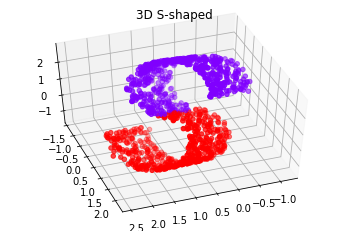

(2,)


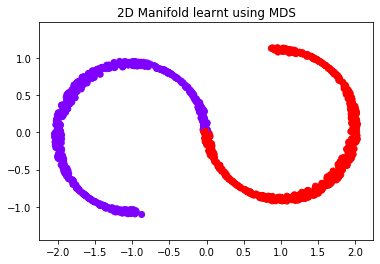

(2,)


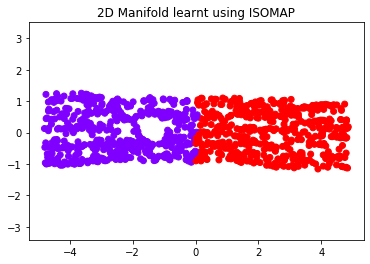

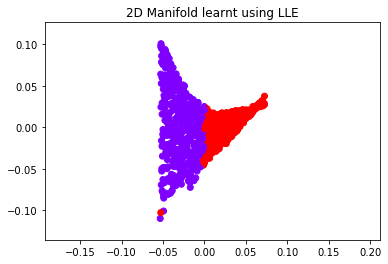

In [18]:
#  Visualization code here
colorize = dict(c=St, cmap=plt.cm.get_cmap('rainbow', 2))
def random_projection(X, dimension=3, rseed=42):
    assert dimension >= X.shape[1]
    rng = np.random.RandomState(rseed)
    C = rng.randn(dimension, dimension)
    e, V = np.linalg.eigh(np.dot(C, C.T))
    return np.dot(X, V[:X.shape[1]])
    
X3 = random_projection(SX, 3)
print(X3.shape)

# Plot the higher dimensional data
from mpl_toolkits import mplot3d

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(X3[:, 0], X3[:, 1], X3[:, 2],
             **colorize)
ax.view_init(azim=70, elev=50)
plt.title('3D S-shaped')
plt.show()

# 2D Manifold learnt using MDS
Y = MDS(SX,10)
plt.scatter(Y[:, 0], Y[:, 1], **colorize)
plt.title('2D Manifold learnt using MDS')
plt.axis('equal');
plt.show()

# 2D Manifold learnt using ISOMAP
Y = ISOMAP(SX,10)
Y = np.array(Y)
plt.scatter(Y[:, 0], Y[:, 1], **colorize)
plt.title('2D Manifold learnt using ISOMAP')
plt.axis('equal');
plt.show()

# 2D Manifold learnt using LLE
Y = LLE(SX,10)
Y = np.array(Y)
plt.scatter(Y[:, 0], Y[:, 1], **colorize)
plt.title('2D Manifold learnt using LLE')
plt.axis('equal');
plt.show()


# Question 3: Clustering and Visualizing high-dimensional data
Perform k-means and spectral clustering on the Swiss roll dataset and visualize using the above 3 methods. State your observations.

In [13]:
# Swiss roll dataset loading here
#from google.colab import drive
#drive.mount("/content/drive", force_remount=True)
d = []
with open('./swissroll.dat', 'r') as dat_file:
    for line in dat_file:
        line = line.strip().split()
        line = [float(x.strip()) for x in line]
        d.append(line)
swissroll = np.array(d)
print (swissroll.shape)

(1600, 3)


Procedure for this question:
1. Perform spectral clustering (2 clusters) on the unchanged Swiss roll and visualize (binary colors)
2. Unwrap the manifold in 2D and visualize using
  - MDS
  - ISOMAP
  - LLE

Use the labels from the spectral clustering to color the unwrapped manifolds.

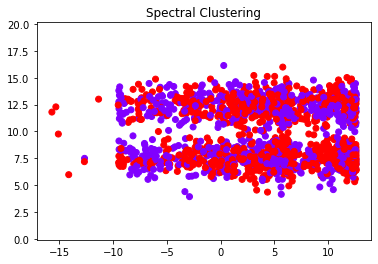

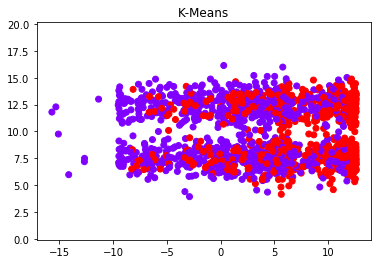

(1600, 3)


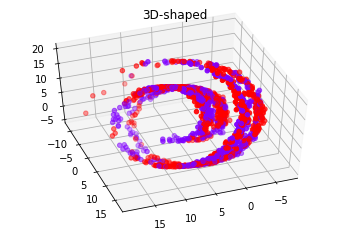

(2,)


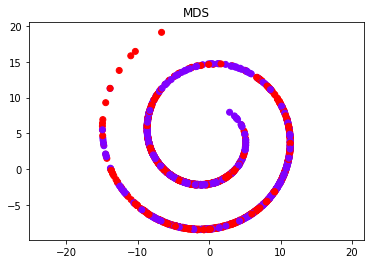

(2,)


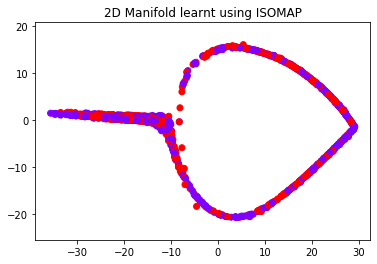

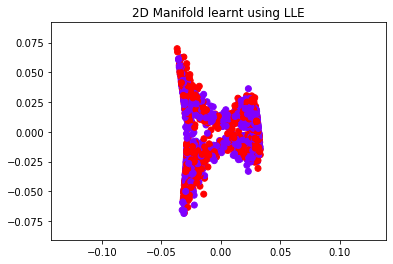

In [24]:
# CODE HERE

colorize = dict(c=CY_Pred, cmap=plt.cm.get_cmap('rainbow', 2))

CY_Pred = spectral_clustering(swissroll)
plt.scatter(swissroll[:, 0], swissroll[:, 1], **colorize)
plt.title('Spectral Clustering')
plt.axis('equal');
plt.show()

kmeans = KMeans(n_clusters=2)
kmeans.fit(swissroll)
y_kmeans = kmeans.predict(swissroll)
plt.scatter(swissroll[:, 0], swissroll[:, 1], c=y_kmeans , cmap=plt.cm.get_cmap('rainbow', 2))
plt.title('K-Means')
plt.axis('equal');
plt.show()


def random_projection(X, dimension=3, rseed=42):
    assert dimension >= X.shape[1]
    rng = np.random.RandomState(rseed)
    C = rng.randn(dimension, dimension)
    e, V = np.linalg.eigh(np.dot(C, C.T))
    return np.dot(X, V[:X.shape[1]])
    
X3 = random_projection(swissroll, 3)
print(X3.shape)

# Plot the higher dimensional data
from mpl_toolkits import mplot3d

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(X3[:, 0], X3[:, 1], X3[:, 2],
             **colorize)
ax.view_init(azim=70, elev=50)
plt.title('3D-shaped')
plt.show()


# 2D Manifold learnt using MDS
Y = MDS(swissroll,20)
plt.scatter(Y[:, 0], Y[:, 1], **colorize)
plt.title('MDS')
plt.axis('equal');
plt.show()

# 2D Manifold learnt using ISOMAP
Y = ISOMAP(swissroll,20)
Y = np.array(Y)
plt.scatter(Y[:, 0], Y[:, 1], **colorize)
plt.title('2D Manifold learnt using ISOMAP')
plt.axis('equal');
plt.show()

# 2D Manifold learnt using LLE
Y = LLE(swissroll,20)
Y = np.array(Y)
plt.scatter(Y[:, 0], Y[:, 1], **colorize)
plt.title('2D Manifold learnt using LLE')
plt.axis('equal');
plt.show()


If we closely look at the data in 3D, we can see a certain amount of gap in swiss roll which is clearly visible after performing spectral clustering and KMeans. The above examples are based on k=10 nearest neighbours. 
We can see that unwarp of this particular swiss roll data is not proper for MDS, ISOMAP and LLE.
1. Since MDS is based on pairwise distances hence it does not unwrap the swissroll.
2. In ISOMAP because geodesic distance is calculated and shortest path based on nearest neighbours, it also failes to unwarp the swissroll because of gap in data.(as obseerved using spectral clustering, Kmeans and 3d shaped plot).
3. LLE performs better than the previous two, if K is increased we can completely unwrap the swissroll properly.



---



# Question 4: Classification

Perform classification using a machine learning algorithm of your choice. Use 6k images from CIFAR-10 dataset.(5k images for training and 1k images for testing.)


*   Do dimensionality reduction on the dataset using PCA and ISOMAP.
*   Apply the classification algorithm.
*   Compare the results by changing the dimensionality of the data.
*   Use F1-score as metric.
*   Approach: Reduce the dimensionality into any two dimensions(of your choice) which are less than the initial dimensionality of the data using PCA and ISOMAP. Compare the performance metrics(F1-score) for the low dimensional data.



In [2]:
# Code for loading CIFAR-10 dataset.
from keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train = X_train[:5000].reshape([5000,32*32*3])
y_train = y_train[:5000]
X_test = X_test[:1000].reshape([1000,32*32*3])
y_test = y_test[:1000]
# Initial dimensionality/number of features (32*32*3) = 3072.

Using TensorFlow backend.


In [0]:
def reductionUsingPCA(X, k, output_dim):
  """Args:
    X: numpy.array [n_samples, input_dim]
    k: number of nearest neighbours to construct the knn graph
    output_dim: dimension of output data

    Returns:
    pca_X: numpy.array [n_samples, output_dim]
  """
  # Enter your code here
  pca = PCA(n_components=output_dim, svd_solver='randomized')
  pca_X = pca.fit_transform(X)
  return pca_X

In [0]:
def reductionUsingISOMAP(X, k, output_dim):
  """Args:
    X: numpy.array [n_samples, input_dim]
    k: number of nearest neighbours to construct the knn graph
    output_dim: dimension of output data

    Returns:
    isomap_X: numpy.array [n_samples, output_dim]
  """
  # Enter your code here
  isomap_X = Isomap(n_components=output_dim, n_neighbors=k).fit_transform(X)
  return isomap_X

In [0]:
# Classification Algorithm 
# Extra functions here

def classification(X_train, y_train, X_test, n_classes):
  """Args:
    X: numpy.array [n_samples, input_dim]
    n_classes: number of classes

    Returns:
    labels: numpy_array [n_samples]
  """
  # Your code here
  clf = LogisticRegression(random_state=0).fit(X_train, y_train)
  labels = clf.predict(X_test)
  return labels


In [0]:
def F1_score(y_true, y_pred):
  """Args:
    y_true: numpy.array [n_samples] , ground truth value
    y_pred: numpy.array [n_samples] , predicted value by classifier
    
    Returns:
    score: float, f1-score
  """
  # Enter your code here
  cm = confusion_matrix(y_true, y_pred)
  score = f1_score(y_true, y_pred, average='macro')
  return score

In [0]:
X_pca_1 = reductionUsingPCA(np.concatenate([X_train, X_test]), 1, 500)
X_train_pca_1 = X_pca_1[:5000]
X_test_pca_1= X_pca_1[5000:]

X_pca_2 = reductionUsingPCA(np.concatenate([X_train, X_test]), 1, 100)
X_train_pca_2 = X_pca_2[:5000]
X_test_pca_2= X_pca_2[5000:]

X_iso_1 = reductionUsingISOMAP(np.concatenate([X_train, X_test]), 200, 500)
X_train_iso_1 = X_iso_1[:5000]
X_test_iso_1= X_iso_1[5000:]

X_iso_2 = reductionUsingISOMAP(np.concatenate([X_train, X_test]), 200, 100)
X_train_iso_2 = X_iso_2[:5000]
X_test_iso_2= X_iso_2[5000:]

In [0]:
y1 = classification(X_train_pca_1,y_train,X_test_pca_1, 10)
y2 = classification(X_train_pca_2,y_train,X_test_pca_2, 10)
y3 = classification(X_train_iso_1,y_train,X_test_iso_1, 10)
y4 = classification(X_train_iso_2,y_train,X_test_iso_2, 10)

In [18]:
print("F1_Scores :\n")
print("PCA 1: ",F1_score(y_test,y1))
print("ISO 1: ",F1_score(y_test,y3))
print("\nPCA 2: ",F1_score(y_test,y2))
print("ISO 2: ",F1_score(y_test,y4))

F1_Scores :

PCA 1:  0.27354143326029046
ISO 1:  0.2880981594980701

PCA 2:  0.35828324342006734
ISO 2:  0.32263887174215145


1. In First experiment I have used PCA and ISOMAP to reduce dimensions to 500. I achieved an F1 score of 0.273 and 0.288 for PCA and ISOMAP.

2. In Second experiment I have used PCA and ISOMAP to reduce dimensions to 100. I achieved an F1 score of 0.358 and 0.322 for PCA and ISOMAP.

On both experiments Logistic Regression is used for classification. We can see that as dimesionality is reduced to 100 we obtain low false positives and false negatives as compared to first experiment.
And if we compare PCA and ISOMAP, PCA projection where images that do not have similar shapes can lie next to each other. The PCA projection, being a linear reduction, is maybe good at picking up on linear correlations such as between the pixel values but the Isomap projection may find meaningful correlations that are not linear.